### Import packages

In [1]:
import os
import sys
import warnings

import datetime
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th

import os
import pickle

import gymnasium as gym
import matplotlib.pyplot as plt

from datetime import datetime
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure  # Import the configure function
from stable_baselines3.common.utils import polyak_update, set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from scripts.utils import NumpyEncoder
from scripts.logger import *

import json


import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)

### Hyperparameters


In [2]:
# Constants and Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 100000
BATCH_SIZE = 256*4
TARGET_UPDATE_INTERVAL = 1000

NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4

EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 95
# EXPLORATION_PHASE = 1000

MAX_TOTAL_TIMESTEPS = 1000

EPSILON_TYPE = "exponential"
# EPSILON_TYPE = "linear"


if EPSILON_TYPE == "linear":
    EPSILON_MIN = 0

N_EPISODES = 500


cross_val_flag = False
CROSS_VAL_INTERVAL = N_EPISODES/100

# TRAINING_FOLDERS_PATH = "../data/Locked/alpha/"
# TRAINING_FOLDERS_PATH = "../data/Training/3ac-10/"
# TRAINING_FOLDERS_PATH = "../data/Training/temp/"
TRAINING_FOLDERS_PATH = "../data/Training/3ac-10-deterministic/"
TESTING_FOLDERS_PATH = "../data/Training/3ac-10-deterministic/"

stripped_scenario_folder = TRAINING_FOLDERS_PATH.split("/")[-2]
print(f"Training on {stripped_scenario_folder}")
# extract number of scenarios in training and testing folders
num_scenarios_training = len(os.listdir(TRAINING_FOLDERS_PATH))



Training on 3ac-10-deterministic


## ESTIMATED VALUES

Calculating...

Calculating reward for action: flight 7, aircraft 0
  +0 for resolving 0 eligible conflicts (excluding cancellations)
  -0 penalty for 0 minutes of additional delay (capped at 1000000)
  -0 penalty for 0 new cancelled flights: set()
  -0 penalty for inaction with remaining conflicts
  -60.0 penalty for time progression
  +-60.0 termination reward (0 - 60.0)
[  60.   60.  810.   nan -120.    0.    0.    0.    0.    0.   60.  -60.
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan]
--------------------------------
Total reward: -120.0
--------------------------------

Calculating reward for action: flight 8, aircraft 1
  +900 for resolving 1 eligible conflicts (excluding cancellations)
  -579.0 penalty for 579.0 minutes of additional delay (capped at 1000000)
  -0 penalty for 0 new cancelled flights: set()
  -0 penalty for inaction with remaining conflic

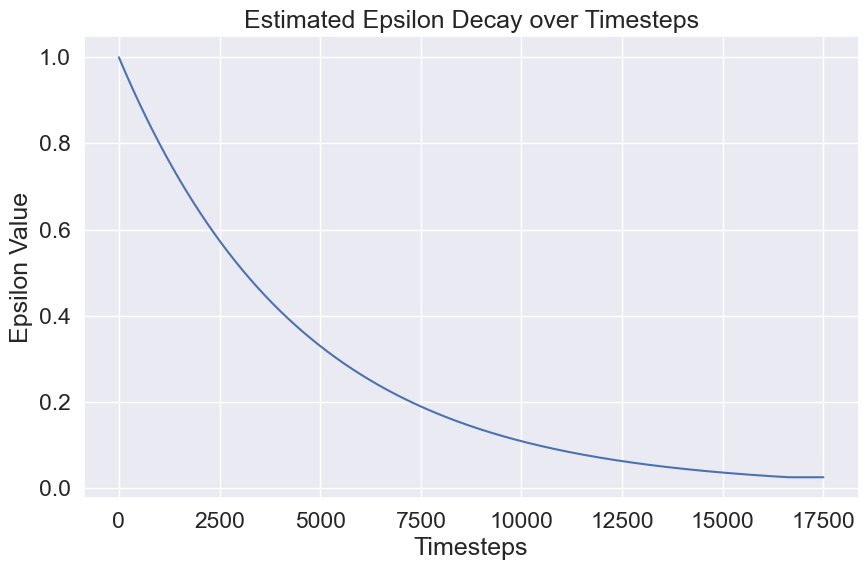

EPSILON DECAY RATE:  0.00022188748596174053


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.environment import AircraftDisruptionEnv

print("Calculating...")
# Calculate total timesteps 10 times and take the average
total_timesteps_list = [calculate_total_training_timesteps(TRAINING_FOLDERS_PATH, N_EPISODES) for _ in range(1)]
estimated_total_timesteps = sum(total_timesteps_list) / len(total_timesteps_list)

print("Estimated total timesteps: ", estimated_total_timesteps)

# Calculate the decay rate or linear rate
EPSILON_DECAY_RATE = calculate_epsilon_decay_rate(
    estimated_total_timesteps,
    EPSILON_START,
    EPSILON_MIN,
    PERCENTAGE_MIN,
    EPSILON_TYPE
)

print("")
print("Testing...")
simulate_and_plot_epsilon_decay(
    EPSILON_START, EPSILON_MIN, EPSILON_DECAY_RATE, estimated_total_timesteps, EPSILON_TYPE
)

EPSILON_DECAY_RATE = EPSILON_DECAY_RATE
print("EPSILON DECAY RATE: ", EPSILON_DECAY_RATE)


In [4]:
# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
# print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
        f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
MODEL_SAVE_PATH = f'../trained_models/dqn/'

# myopic_model_name = "myopic_3ac"
# proactive_model_name = "proactive_3ac"
# myopic_model_version = get_model_version(myopic_model_name, myopic_proactive="myopic", drl_type="dqn")
# proactive_model_version = get_model_version(proactive_model_name, myopic_proactive="proactive", drl_type="dqn")

# myopic_model_path = f"{MODEL_SAVE_PATH}{myopic_model_name}-{myopic_model_version}.zip"
# proactive_model_path = f"{MODEL_SAVE_PATH}{proactive_model_name}-{proactive_model_version}.zip"
# print(f"Models will be saved to:")
# print(f"   {myopic_model_path}")
# print(f"   {proactive_model_path}")

# Create results directory
results_dir = create_results_directory(append_to_name='dqn')
print(f"Results directory created at: {results_dir}")








Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training on 5000 days of data (500 episodes of 10 scenarios)
Results directory created at: ../results/dqn/20241207-02-11


# Reinforcement Learning

## Training

In [5]:
from scripts.logger import create_new_id, get_config_variables
import src.config as config

# Training both agents: myopic and proactive

def train_dqn_agent(env_type):
    log_data = {}  # Main dictionary to store all logs

    config_variables = get_config_variables(config)

    # Generate unique ID for training
    training_id = create_new_id("training")
    runtime_start_in_seconds = time.time()

    if env_type == "myopic":
        model_path = f"../trained_models/dqn/myopic-{training_id}.zip"
        print(f"Models will be saved to: {model_path}")
        model_path_and_name = model_path
    elif env_type == "proactive":
        model_path = f"../trained_models/dqn/proactive-{training_id}.zip"
        print(f"Models will be saved to: {model_path}")
        model_path_and_name = model_path
    # Metadata for logging
    training_metadata = {
        "myopic_or_proactive": env_type,
        "model_type": "dqn",
        "training_id": training_id,
        "MODEL_SAVE_PATH": model_path,
        "N_EPISODES": N_EPISODES,
        "num_scenarios_training": num_scenarios_training,
        "results_dir": results_dir,
        "CROSS_VAL_FLAG": cross_val_flag,
        "CROSS_VAL_INTERVAL": CROSS_VAL_INTERVAL,
        **config_variables,
        "LEARNING_RATE": LEARNING_RATE,
        "GAMMA": GAMMA,
        "BUFFER_SIZE": BUFFER_SIZE,
        "BATCH_SIZE": BATCH_SIZE,
        "TARGET_UPDATE_INTERVAL": TARGET_UPDATE_INTERVAL,
        "EPSILON_START": EPSILON_START,
        "EPSILON_MIN": EPSILON_MIN,
        "EPSILON_DECAY_RATE": EPSILON_DECAY_RATE,
        "LEARNING_STARTS": LEARNING_STARTS,
        "TRAIN_FREQ": TRAIN_FREQ,
        "NEURAL_NET_STRUCTURE": NEURAL_NET_STRUCTURE,
        "device_info": str(get_device_info(device)),
        "TRAINING_FOLDERS_PATH": TRAINING_FOLDERS_PATH,
        "TESTING_FOLDERS_PATH": TESTING_FOLDERS_PATH,
        "runtime_start": datetime.utcnow().isoformat() + "Z",
        "runtime_start_in_seconds": runtime_start_in_seconds,
    }

    log_data['metadata'] = training_metadata
    log_data['episodes'] = {}
    log_data['cross_validation'] = {}

    best_reward_avg = float('-inf')
    # Initialize variables
    rewards = {}
    good_rewards = {}
    test_rewards = []
    epsilon_values = []
    total_timesteps = 0  # Added to track total timesteps
    consecutive_drops = 0  # Track consecutive performance drops
    best_test_reward = float('-inf')  # Track best test performance
    action_sequences = {
        os.path.join(TRAINING_FOLDERS_PATH, folder): {
            "best_actions": [],
            "best_reward": float('-inf'),
            "worst_actions": [],
            "worst_reward": float('inf')
        }
        for folder in training_folders
    }
    
    def cross_validate_on_test_data(model, current_episode, log_data):
        cross_val_data = {
            "episode": current_episode,
            "scenarios": [],
            "avg_test_reward": 0,
        }

        test_scenario_folders = [
            os.path.join(TESTING_FOLDERS_PATH, folder)
            for folder in os.listdir(TESTING_FOLDERS_PATH)
            if os.path.isdir(os.path.join(TESTING_FOLDERS_PATH, folder))
        ]
        total_test_reward = 0
        for test_scenario_folder in test_scenario_folders:
            scenario_data = {
                "scenario_folder": test_scenario_folder,
                "total_reward": 0,
                "steps": []
            }
            # Load data
            data_dict = load_scenario_data(test_scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            from src.environment import AircraftDisruptionEnv
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Evaluate the model on the test scenario without training
            obs, _ = env.reset()

            done_flag = False
            total_reward = 0
            timesteps = 0

            while not done_flag:
                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -np.inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                # Select the action with the highest masked Q-value
                action = np.argmax(masked_q_values)

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result
                obs_next, reward, terminated, truncated, info = result

                done_flag = terminated or truncated

                # Accumulate the reward
                total_reward += reward

                # Update the current observation
                obs = obs_next

                scenario_data["steps"].append({
                    "step_number": timesteps + 1,
                    "action": action,
                    "flight_action": env.map_index_to_action(action)[0],
                    "aircraft_action": env.map_index_to_action(action)[1],
                    "reward": reward,
                    "total_timestep": total_timesteps,
                    "time_in_scenario": timesteps,
                    "epsilon": "1.0 at cross-validation",
                    "action_reason": "exploitation at cross-validation",
                    "action_mask": action_mask,
                    "action_mask_sum": np.sum(action_mask),
                    "len_action_mask": len(action_mask),
                    "masked_q_values": masked_q_values,
                    "q_values": q_values,
                    "info_after_step": env.info_after_step,
                    # Assuming impact_of_action is defined elsewhere
                    # "impact_of_action": impact_of_action,
                })

                timesteps += 1
                if done_flag:
                    break

            total_test_reward += total_reward

            scenario_data["total_reward"] = total_reward
            cross_val_data["scenarios"].append(scenario_data)

        # Compute average test reward
        avg_test_reward = total_test_reward / len(test_scenario_folders)
        cross_val_data["avg_test_reward"] = avg_test_reward
        test_rewards.append((current_episode, avg_test_reward))
        print(f"cross-val done at episode {current_episode}")

        # Store cross-validation data in log_data
        log_data['cross_validation'][current_episode] = cross_val_data

        return avg_test_reward  # Return the average test reward

    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    total_timesteps = 0  # Reset total_timesteps for each agent

    # Initialize the DQN
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    from src.environment import AircraftDisruptionEnv

    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict,
        env_type=env_type
    )

    model = DQN(
        policy='MultiInputPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device=device
    )

    logger = configure()
    model._logger = logger

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # create a dictionary in the rewards dictionary for the current episode
        rewards[episode] = {}
        # create a dictionary in the action_sequences dictionary for the current episode
        action_sequences[episode] = {}
        # Log the start of the episode
        episode_data = {
            "episode_number": episode + 1,
            "epsilon_start": epsilon,
            "scenarios": {},
        }
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            scenario_data = {
                "scenario_folder": scenario_folder,
                "steps": [],
                "total_reward": 0,
            }
            # create a dictionary in the rewards dictionary for the current scenario
            rewards[episode][scenario_folder] = {}
            # create a dictionary in the action_sequences dictionary for the current scenario
            action_sequences[episode][scenario_folder] = []
            best_reward = float('-inf')
            best_action_sequence = []
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag:

                # Get cancelled flights
                num_cancelled_flights_before_step = len(env.cancelled_flights)  # Returns a set of flight IDs

                # Get delayed flights and their delays (in minutes)
                num_delayed_flights_before_step = len(env.environment_delayed_flights)  # Returns a dict of {flight_id: delay_minutes}

                # Get flights that have already been penalized for delays
                num_penalized_delays_before_step = len(env.penalized_delays)  # Returns a dict of {flight_id: delay_minutes}

                # Get flights that have already been penalized for being cancelled
                num_penalized_cancelled_before_step = len(env.penalized_cancelled_flights)  # Returns a set of flight IDs

                model.exploration_rate = epsilon

                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -np.inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                current_seed = int(time.time() * 1e9) % (2**32 - 1)
                # print(current_seed)
                np.random.seed(current_seed)
                
                brute_force_flag = False
                # Select an action
                action_reason = "None"
                if np.random.rand() < epsilon or brute_force_flag:
                    # Exploration: choose a random valid action
                    valid_actions = np.where(action_mask == 1)[0]
                    action = np.random.choice(valid_actions)
                    action_reason = "exploration"
                else:
                    # Exploitation: choose the action with the highest masked Q-value
                    action = np.argmax(masked_q_values)
                    action_reason = "exploitation"

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Store the reward for the current timestep
                rewards[episode][scenario_folder][timesteps] = reward
                action_sequences[episode][scenario_folder].append(action)

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                    
                epsilon_values.append((episode + 1, epsilon))

                timesteps += 1
                total_timesteps += 1  # Update total_timesteps

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                num_cancelled_flights_after_step = len(env.cancelled_flights)
                num_delayed_flights_after_step = len(env.environment_delayed_flights)
                num_penalized_delays_after_step = len(env.penalized_delays)
                num_penalized_cancelled_after_step = len(env.penalized_cancelled_flights)

                impact_of_action = {
                    "num_cancelled_flights": num_cancelled_flights_after_step - num_cancelled_flights_before_step,
                    "num_delayed_flights": num_delayed_flights_after_step - num_delayed_flights_before_step,
                    "num_penalized_delays": num_penalized_delays_after_step - num_penalized_delays_before_step,
                    "num_penalized_cancelled": num_penalized_cancelled_after_step - num_penalized_cancelled_before_step,
                }

                scenario_data["steps"].append({
                    "step_number": timesteps,
                    "action": action,
                    "flight_action": env.map_index_to_action(action)[0],
                    "aircraft_action": env.map_index_to_action(action)[1],
                    "reward": reward,
                    "total_timestep": total_timesteps,
                    "time_in_scenario": timesteps,
                    "epsilon": epsilon,
                    "action_reason": action_reason,
                    "impact_of_action": impact_of_action,
                    "done_flag": done_flag,
                    "action_mask_sum": np.sum(action_mask),
                    "len_action_mask": len(action_mask),
                    "info_after_step": env.info_after_step,
                    "masked_q_values": masked_q_values,
                    "q_values": q_values,
                    "action_mask": action_mask,
                })
                
                # Check if the episode is done
                if done_flag:
                    break
            
            total_reward = 0
            for _, reward in rewards[episode][scenario_folder].items():
                total_reward += reward
            # Store the total reward for the episode with the scenario specified
            rewards[episode][scenario_folder] = total_reward


            # save the action sequence
            action_sequences[episode][scenario_folder] = action_sequence

            # Summarize scenario
            scenario_data["total_reward"] = total_reward
            episode_data["scenarios"][scenario_folder] = scenario_data

        # Perform cross-validation at specified intervals
        if cross_val_flag:
            # Initialize best_test_reward and current_test_reward at first cross validation
            if (episode + 1) % CROSS_VAL_INTERVAL == 0:
                current_test_reward = cross_validate_on_test_data(model, episode + 1, log_data)
                if not hasattr(train_dqn_agent, 'best_test_reward'):
                    train_dqn_agent.best_test_reward = current_test_reward
                best_test_reward = train_dqn_agent.best_test_reward
            
                # Early stopping logic
                if current_test_reward < best_test_reward:
                    consecutive_drops += 1
                    print(f"Performance drop {consecutive_drops}/5 (current: {current_test_reward:.2f}, best: {best_test_reward:.2f})")
                    if consecutive_drops >= 500:
                        print(f"Early stopping triggered at episode {episode + 1} due to 5 consecutive drops in test performance")
                        break
                else:
                    consecutive_drops = 0
                    train_dqn_agent.best_test_reward = current_test_reward
                    best_test_reward = current_test_reward

        # Calculate the average reward for this batch of episodes
        avg_reward_for_this_batch = 0
        for i in range(len(scenario_folders)):
            avg_reward_for_this_batch += rewards[episode][scenario_folders[i]]
        avg_reward_for_this_batch /= len(scenario_folders)

        # Append the avg reward for this batch to rewards
        rewards[episode + 1] = avg_reward_for_this_batch

        good_rewards[episode + 1] = avg_reward_for_this_batch
        if avg_reward_for_this_batch > best_reward_avg:
            best_reward_avg = avg_reward_for_this_batch
        print(f"{env_type}: ({episode + 1}/{N_EPISODES}) {epsilon:.2f} best avg: {best_reward_avg:.2f} - rewards avg: {avg_reward_for_this_batch:.2f}")
        # print(f"Total avg rewards for this batch: {avg_reward_for_this_batch}")

        # Summarize episode
        episode_data["avg_reward"] = avg_reward_for_this_batch
        log_data['episodes'][episode + 1] = episode_data

    # Save the model after training
    if env_type == "myopic":
        model.save(f"../trained_models/dqn/myopic-{training_id}.zip")
    else:
        model.save(f"../trained_models/dqn/proactive-{training_id}.zip")

    runtime_end_in_seconds = time.time()
    runtime_in_seconds = runtime_end_in_seconds - runtime_start_in_seconds

    actual_total_timesteps = total_timesteps

    training_summary = {
        "runtime_seconds": runtime_in_seconds,
        "total_timesteps": total_timesteps,
        "final_rewards": good_rewards,
        "episodes_trained": episode + 1,
        "actual_total_timesteps": actual_total_timesteps,
    }
    log_data['training_summary'] = training_summary

    # Include all other relevant data
    log_data['average_batch_episode_rewards'] = good_rewards
    log_data['test_rewards'] = test_rewards
    log_data['epsilon_values'] = epsilon_values
    log_data['action_sequences'] = action_sequences
    log_data['rewards'] = rewards

    # Write all data to the log file at once
    log_file_path = os.path.join("../logs", "training", f"training_{training_id}.json")
    
    # make log_data serializable
    log_data = convert_to_serializable(log_data)
    with open(log_file_path, 'w') as log_file:
        json.dump(log_data, log_file, indent=4, cls=NumpyEncoder)


    finalize_training_log(training_id, training_summary, model_path)

    # Return collected data
    return rewards, test_rewards, total_timesteps, epsilon_values, good_rewards, action_sequences, model_path_and_name


In [6]:
import random

# Number of seeds
NUM_SEEDS = 1
SEEDS = [0]

# We will store runs for both myopic and proactive
all_myopic_runs = []
all_proactive_runs = []
all_myopic_steps_runs = []
all_proactive_steps_runs = []

def run_training_for_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)
    if th.cuda.is_available():
        th.cuda.manual_seed_all(seed)

    # Train myopic agent
    results_myopic = train_dqn_agent('myopic')
    
    rewards_myopic, test_rewards_myopic, total_timesteps_myopic, epsilon_values_myopic, good_rewards_myopic, action_sequences_myopic, model_path_and_name_myopic = results_myopic
    print(f"len(rewards_myopic): {len(rewards_myopic)}")
    # Train proactive agent
    results_proactive = train_dqn_agent('proactive')
    rewards_proactive, test_rewards_proactive, total_timesteps_proactive, epsilon_values_proactive, good_rewards_proactive, action_sequences_proactive, model_path_and_name_proactive = results_proactive
    print(f"len(rewards_proactive): {len(rewards_proactive)}")

    episodes_myopic = sorted(good_rewards_myopic.keys())
    episodes_proactive = sorted(good_rewards_proactive.keys())

    if len(episodes_myopic) > 0:
        myopic_steps = np.linspace(0, total_timesteps_myopic, len(episodes_myopic))
    else:
        myopic_steps = np.array([])
    if len(episodes_proactive) > 0:
        proactive_steps = np.linspace(0, total_timesteps_proactive, len(episodes_proactive))
    else:
        proactive_steps = np.array([])

    myopic_rewards_run = np.array([good_rewards_myopic[e] for e in episodes_myopic])
    proactive_rewards_run = np.array([good_rewards_proactive[e] for e in episodes_proactive])

    return myopic_rewards_run, proactive_rewards_run, myopic_steps, proactive_steps


# Run training for each seed and store results
for s in SEEDS:
    print(f"Running DQN training for seed {s}...")
    myopic_rewards_seed, proactive_rewards_seed, myopic_steps_seed, proactive_steps_seed = run_training_for_seed(s)

    # Only store runs that have episodes
    if len(myopic_rewards_seed) > 0:
        all_myopic_runs.append(myopic_rewards_seed)
        all_myopic_steps_runs.append(myopic_steps_seed)
    if len(proactive_rewards_seed) > 0:
        all_proactive_runs.append(proactive_rewards_seed)
        all_proactive_steps_runs.append(proactive_steps_seed)

# Ensure all runs are of same length by truncation to the shortest length
if len(all_myopic_runs) > 0:
    min_length_myopic = min(len(run) for run in all_myopic_runs)
    all_myopic_runs = [run[:min_length_myopic] for run in all_myopic_runs]
    all_myopic_steps_runs = [steps[:min_length_myopic] for steps in all_myopic_steps_runs]

if len(all_proactive_runs) > 0:
    min_length_proactive = min(len(run) for run in all_proactive_runs)
    all_proactive_runs = [run[:min_length_proactive] for run in all_proactive_runs]
    all_proactive_steps_runs = [steps[:min_length_proactive] for steps in all_proactive_steps_runs]

all_myopic_runs = np.array(all_myopic_runs) if len(all_myopic_runs) > 0 else np.array([])
all_proactive_runs = np.array(all_proactive_runs) if len(all_proactive_runs) > 0 else np.array([])
all_myopic_steps_runs = np.array(all_myopic_steps_runs) if len(all_myopic_steps_runs) > 0 else np.array([])
all_proactive_steps_runs = np.array(all_proactive_steps_runs) if len(all_proactive_steps_runs) > 0 else np.array([])



Running DQN training for seed 0...
Models will be saved to: ../trained_models/dqn/myopic-0717.zip
Device: mps
Using MacBook M1
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-07-02-11-01-653642

Calculating reward for action: flight 1, aircraft 0
  +0 for resolving 0 eligible conflicts (excluding cancellations)
  -0 penalty for 0 minutes of additional delay (capped at 1000000)
  -0 penalty for 0 new cancelled flights: set()
  -0 penalty for inaction with remaining conflicts
  -60.0 penalty for time progression
  +-60.0 termination reward (0 - 60.0)
[  60.   60.  810.   nan -120.    0.    0.    0.    0.    0.   60.  -60.
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan]
--------------------------------
Total reward: -120.0
--------------------------------

Calculating reward for action: flight 1, aircraft 2
  +0 for resolving 0 eligible confli

KeyboardInterrupt: 

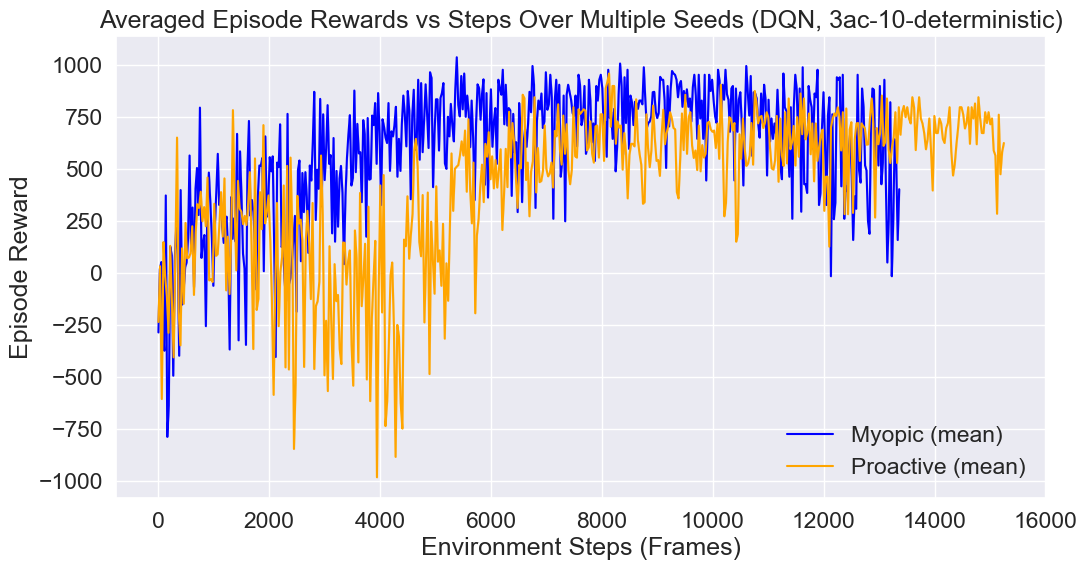

DQN averaged reward vs steps plot saved to ../results/dqn/20241206-23-36/dqn_averaged_rewards_over_steps.png


In [7]:

if all_myopic_runs.size > 0 and all_proactive_runs.size > 0:
    myopic_mean = all_myopic_runs.mean(axis=0)
    myopic_std = all_myopic_runs.std(axis=0)
    myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)

    proactive_mean = all_proactive_runs.mean(axis=0)
    proactive_std = all_proactive_runs.std(axis=0)
    proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)

    # Now plot similarly to PPO
    plt.figure(figsize=(12,6))

    # Set smoothing window
    smooth_window = 1  # Updated smoothing window to 100

    def smooth(data, window):
        if window > 1 and len(data) >= window:
            return np.convolve(data, np.ones(window)/window, mode='valid')
        return data

    myopic_mean_sm = smooth(myopic_mean, smooth_window)
    myopic_std_sm = smooth(myopic_std, smooth_window)
    myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

    proactive_mean_sm = smooth(proactive_mean, smooth_window)
    proactive_std_sm = smooth(proactive_std, smooth_window)
    proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

    plt.plot(myopic_steps_sm, myopic_mean_sm, label="Myopic (mean)", color='blue')
    plt.fill_between(myopic_steps_sm, myopic_mean_sm - myopic_std_sm, myopic_mean_sm + myopic_std_sm, alpha=0.2, color='blue')

    plt.plot(proactive_steps_sm, proactive_mean_sm, label="Proactive (mean)", color='orange')
    plt.fill_between(proactive_steps_sm, proactive_mean_sm - proactive_std_sm, proactive_mean_sm + proactive_std_sm, alpha=0.2, color='orange')
    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    plt.title(f"Averaged Episode Rewards vs Steps Over Multiple Seeds (DQN, {stripped_scenario_folder})")
    plt.legend(frameon=False)
    plt.grid(True)

    plot_file = os.path.join(results_dir, "dqn_averaged_rewards_over_steps.png")
    plt.savefig(plot_file)
    plt.show()
    print(f"DQN averaged reward vs steps plot saved to {plot_file}")
else:
    print("No data to plot. Please check if training returned valid episodes and rewards.")

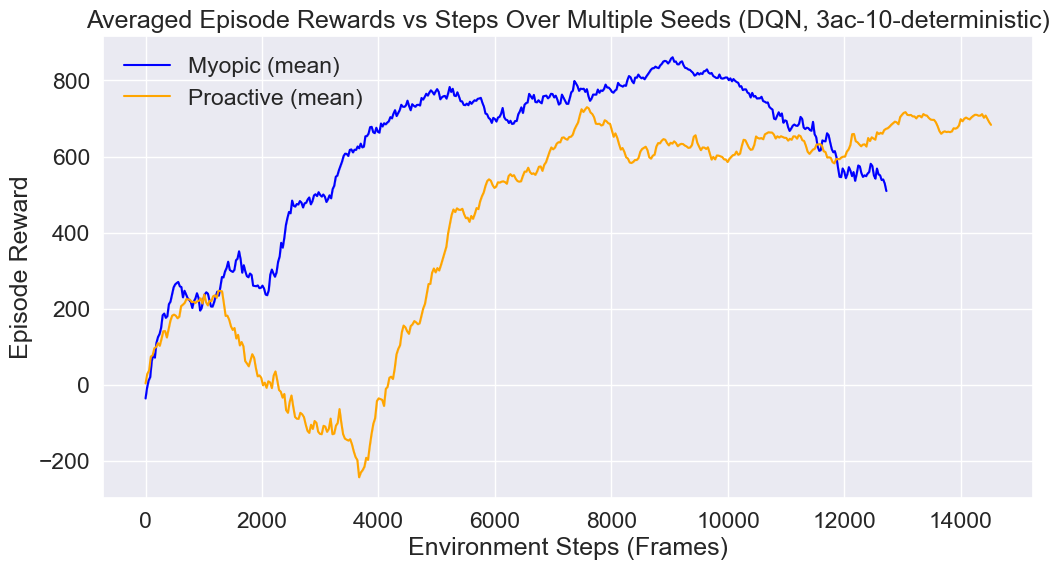

DQN averaged reward vs steps plot saved to ../results/dqn/20241206-23-36/dqn_averaged_rewards_over_steps.png


In [8]:

if all_myopic_runs.size > 0 and all_proactive_runs.size > 0:
    myopic_mean = all_myopic_runs.mean(axis=0)
    myopic_std = all_myopic_runs.std(axis=0)
    myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)

    proactive_mean = all_proactive_runs.mean(axis=0)
    proactive_std = all_proactive_runs.std(axis=0)
    proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)

    # Now plot similarly to PPO
    plt.figure(figsize=(12,6))

    # Set smoothing window
    smooth_window = 25 # Updated smoothing window to 100

    def smooth(data, window):
        if window > 1 and len(data) >= window:
            return np.convolve(data, np.ones(window)/window, mode='valid')
        return data

    myopic_mean_sm = smooth(myopic_mean, smooth_window)
    myopic_std_sm = smooth(myopic_std, smooth_window)
    myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

    proactive_mean_sm = smooth(proactive_mean, smooth_window)
    proactive_std_sm = smooth(proactive_std, smooth_window)
    proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

    plt.plot(myopic_steps_sm, myopic_mean_sm, label="Myopic (mean)", color='blue')
    plt.fill_between(myopic_steps_sm, myopic_mean_sm - myopic_std_sm, myopic_mean_sm + myopic_std_sm, alpha=0.2, color='blue')

    plt.plot(proactive_steps_sm, proactive_mean_sm, label="Proactive (mean)", color='orange')
    plt.fill_between(proactive_steps_sm, proactive_mean_sm - proactive_std_sm, proactive_mean_sm + proactive_std_sm, alpha=0.2, color='orange')
    
    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    plt.title(f"Averaged Episode Rewards vs Steps Over Multiple Seeds (DQN, {stripped_scenario_folder})")
    plt.legend(frameon=False)
    plt.grid(True)

    plot_file = os.path.join(results_dir, "dqn_averaged_rewards_over_steps.png")
    plt.savefig(plot_file)
    plt.show()
    print(f"DQN averaged reward vs steps plot saved to {plot_file}")
else:
    print("No data to plot. Please check if training returned valid episodes and rewards.")